In [265]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from scipy.stats import multinomial
from scipy.optimize import minimize

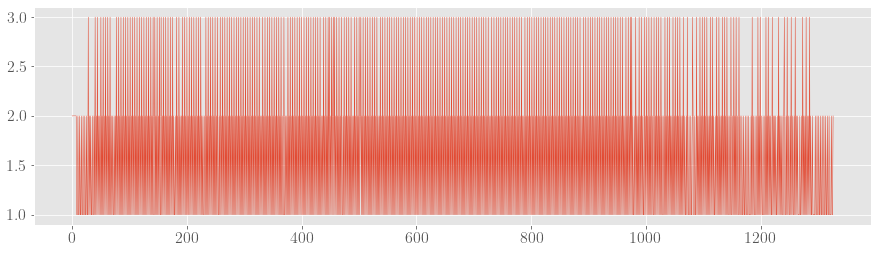

In [266]:
data = pd.read_csv('../data/WoodPewee-2.csv')
plt.figure(figsize=(15, 4))
plt.plot(data['x'], lw=.5)

In [283]:
def find_number_transitions(data, first_state, second_state):
    idx_first_state = np.argwhere(data == first_state).flatten()
    if idx_first_state[-1] == len(data) - 1:
        idx_first_state = idx_first_state[:-1]
    second_state_vals = data[idx_first_state + 1]
    return np.sum(second_state_vals == second_state)

def find_P_mle(data):
    n_states = len(np.unique(data))
    P = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            P[i, j] = find_number_transitions(data, i+1, j+1) 
    return P / P.sum(axis=0)[:, None]
        

In [284]:
P_mle = find_P_mle(data['x'].to_numpy())
print(P_mle)
eigen = np.linalg.eig(P_mle)
eigen_inv = np.linalg.inv(eigen[1])[0]
eigen_inv / np.sum(eigen_inv)

[[0.09696093 0.50361795 0.39942113]
 [0.97191011 0.01966292 0.00842697]
 [0.99641577 0.00358423 0.        ]]


array([0.52111614, 0.26847662, 0.21040724])

In [111]:
data['x'].to_numpy().shape

(1327,)

In [213]:
def markov_sequence(p_transition: np.array, p_init=[1/3, 1/3, 1/3], sequence_length=data['x'].shape[0]) -> list[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

In [214]:
p_init = np.array([0, 1, 0])


p_transition_example = np.array(
    [[0.6,  0.2, 0.2],
     [0.05, 0.9, 0.05],
     [0.1,  0.2, 0.7]]
)

In [218]:
p_state_t = [p_init]

for i in range(200):  
    p_state_t.append(p_state_t[-1] @ P_mle)

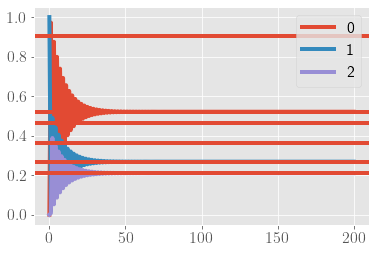

In [223]:
state_distributions = pd.DataFrame(p_state_t)
state_distributions.plot()
[plt.axhline(x) for x in equilibrium_distribution(P_mle)]
[plt.axhline(x) for x in eigen_inv]



In [217]:
def equilibrium_distribution(p_transition):
    n_states = p_transition.shape[0]
    A = np.append(
        arr=p_transition.T - np.eye(n_states),
        values=np.ones(n_states).reshape(1, -1),
        axis=0
    )
    b = np.transpose(np.array([0] * n_states + [1]))
    p_eq = np.linalg.solve(
        a=np.transpose(A).dot(A),
        b=np.transpose(A).dot(b)
    )
    return p_eq

In [25]:
equilibrium_distribution(p_transition_example)

array([0.13333333, 0.66666667, 0.2       ])

In [32]:
def markov_sequence(p_init: np.array, p_transition: np.array, sequence_length: int) -> list[int]:
    """
    Generate a Markov sequence based on p_init and p_transition.
    """
    if p_init is None:
        p_init = equilibrium_distribution(p_transition)
    initial_state = list(multinomial.rvs(1, p_init)).index(1)

    states = [initial_state]
    for _ in range(sequence_length - 1):
        p_tr = p_transition[states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        states.append(new_state)
    return states

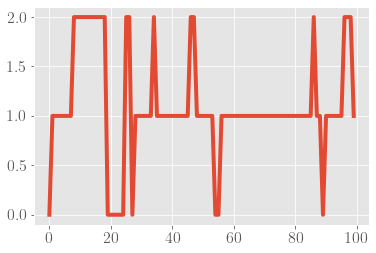

In [33]:
states = markov_sequence(None, p_transition_example, 100)
plt.plot(states)